<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Reading in xGASS data
lgMstar,lgmust,lgSFR_tot_median,SFR_best,SFRerr_best,HIsrc,HI_FLAG,lgMHI,lgGF = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[10,18,1,23,24,26,27,31,32] , unpack= 'true')

In [4]:
# Testing correct columns
print(lgMstar)
print(lgmust)
print(lgSFR_tot_median)
print(SFR_best)
print(SFRerr_best)
print(HIsrc)
print(HI_FLAG)
print(lgMHI)
print(lgGF)

[10.709 10.539 10.625 ... 11.122 10.603 10.25 ]
[9.18 9.05 9.32 ... 9.47 8.71 8.12]
[101866. 101874. 101876. ... 330987. 331571. 332883.]
[0.82985944 0.03869768 0.0620131  ... 2.1113043  3.169239   0.93741816]
[0.         0.07982571 0.15414698 ... 0.36112386 0.29129222 0.28900966]
[3. 4. 3. ... 3. 3. 3.]
[ 1. 99.  1. ...  5.  5.  1.]
[9.603 8.74  9.244 ... 9.945 9.834 9.517]
[-1.106 -1.799 -1.381 ... -1.177 -0.769 -0.733]


In [5]:
# Cleaning up xGASS dataset
# Finding all rows in the xGASS data with HI_FLAG > 1
conf = np.where(HI_FLAG>1)
print(len(conf))
# Query the above
# Removing all the selected rows
lgMstar1 = np.delete(lgMstar, (conf))
lgmust1 = np.delete(lgmust, (conf))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (conf))
SFR_best1 = np.delete(SFR_best, (conf))
SFRerr_best1 = np.delete(SFRerr_best, (conf))
HIsrc1 = np.delete(HIsrc, (conf))
HI_FLAG1 = np.delete(HI_FLAG, (conf))
lgMHI1 = np.delete(lgMHI, (conf))
lgGF1 = np.delete(lgGF, (conf))

# Actually see if it's done the job of removing all rows with value HI_FLAG > 1
print(np.where(HI_FLAG1>1))

# Finding all the rows in the xGASS data with HIsrc > 3, if HIsrc = 4, no detection of HI, if HIsrc > 4, detection of HI
HIdet = np.where(HIsrc < 4)

lgMstar2 = np.delete(lgMstar, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# Actually see if it's done the job of removing all rows with value HIsrc < 4

#print(np.where(HIsrc < 4))

1
(array([], dtype=int64),)


32326595724.789505


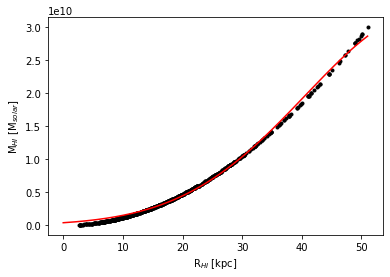

In [6]:
# Finding the Diameter(HI)-to-Mass(HI) relation using, log(DHI) = 0.506*log(MHI) - 3.293
lgDHI = 0.506*lgMHI1-3.292

# Query the above process
# To find the radius of each galaxy we find RHI = 0.5*DHI
RHI = 0.5*(10**(lgDHI))

# Query the below --> profile used is from 0.1R to 1.3R
'''
# Plotting the D(HI)-M(HI) relation
plt.figure()
plt.plot(10**(lgDHI), 10**(lgMHI1), 'k.')
plt.xlabel('D$_{HI}$ [kpc]')
plt.ylabel('M$_{HI}$ [M$_{solar}$]');
'''
# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(RHI, 10**(lgMHI1), 'k.')
plt.xlabel('R$_{HI}$ [kpc]')
plt.ylabel('M$_{HI}$ [M$_{solar}$]')

x = RHI
p = np.linspace(0, max(RHI), 1000)
y = 10**(lgMHI1)
# mean and sigma calculation
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
plt.plot(p, Gauss(p, *popt), 'r-');

grad = popt[0]
print(grad)

In [7]:
# Calculating the HI surface density: (ΣHI)


In [8]:
# Finding MHIout
# >For optical radius < 1.3 integrate ΣHI from optical radius to 1.3
# >For optical radius > 1.3 MHIout = 0



In [9]:
# Finding the median of the HI detections
MMHI = np.column_stack((lgMstar1, lgMHI1))
medHI = np.median(MMHI, axis = 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


"\nplt.subplot(223)\nplt.plot()\nplt.xlabel('log(M*) [Msolar]')\nplt.ylabel('')\nplt.legend(loc='best')\n\nplt.subplot(224)\nplt.plot()\nplt.xlabel('')\nplt.ylabel('')\nplt.legend(loc='best');\n"

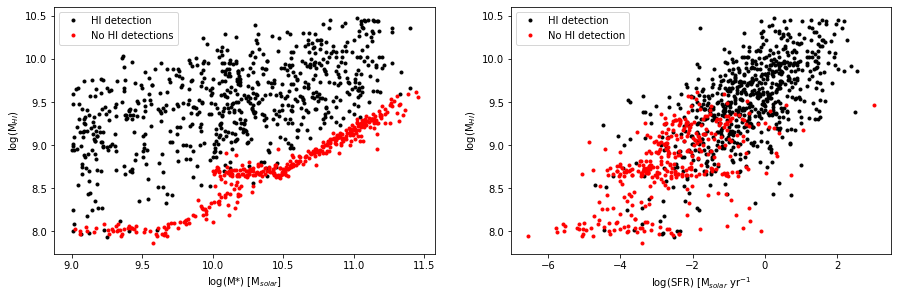

In [10]:
# Atomic gas scaling relation graphs (reproduced from paper)
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'k.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best')

plt.subplot(222)
plt.plot(np.log(SFR_best1), lgMHI1, 'k.', label= 'HI detection')
plt.plot(np.log(SFR_best2), lgMHI2, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='best')
'''
plt.subplot(223)
plt.plot()
plt.xlabel('log(M*) [Msolar]')
plt.ylabel('')
plt.legend(loc='best')

plt.subplot(224)
plt.plot()
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='best');
'''